# Capstone Project
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for delivery service company.
This project is targeting Korean student in KAIST(Korea Advanced Institute of Science and Technology). In Korea, many people use food delivering service. Most of restaurants used to hire their own delivery member, but these days, most of restaurants use delivery service applications.

We will assume that we are trying to make 'Drone Delivery Service' and looking for the optimal location for our 'Drone Base'. We are targeting student in KAIST so, our candidates will be the location near KAIST. But we also consider that there are many other restaurants in Daejeon city.


## Data <a name="data"></a>

To solve our Business Problem we need to figure out the factors below
- number and location of restaurants clusters near KAIST
- distance of clusters from KAIST
- number of Chinese restaurants in the clusters (Chinese food is most popular delivery food)

We will use 'Google Maps API geocoding' and 'Foursquare API' to get locations and categories of the restaurants.

In [2]:
google_api_key=''

In [515]:
import requests

def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    
address = '291 Daehak-ro, Eoeun-dong, Yuseong-gu, Daejeon'
kaistcode = get_coordinates(google_api_key, address)
print('Coordinate of {}: {}'.format(address, kaistcode))

Coordinate of 291 Daehak-ro, Eoeun-dong, Yuseong-gu, Daejeon: [36.3721427, 127.36039]


In [516]:
import shapely.geometry
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('kaistcode longitude={}, latitude={}'.format(kaistcode[1], kaistcode[0]))
x, y = lonlat_to_xy(kaistcode[1], kaistcode[0])
print('kaistcode UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('kaistcode longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
kaistcode longitude=127.36039, latitude=36.3721427
kaistcode UTM X=6630245.909923334, Y=13034867.694239527
kaistcode longitude=127.36038999999957, latitude=36.372142699999365


In [518]:
import folium

In [519]:
map_kaist = folium.Map(location=kaistcode, zoom_start=13)
folium.Marker(kaistcode, popup='KAIST').add_to(map_kaist)
folium.Circle(kaistcode, 
              radius=2500, 
              color='white', 
              fill=True, 
              fill_opacity=0.4).add_to(map_kaist)
map_kaist

### Foursquare

In [13]:
#Foursquare credentials are defined in hidden cell bellow.
foursquare_client_id =''
foursquare_client_secret =''


In [107]:

food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

chinese_category = ['4bf58dd8d48988d145941735']

def is_restaurant(categories, specific_filter=None):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse']
    restaurant = False
    specific = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in restaurant_words:
            if r in category_name:
                restaurant = True
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            restaurant = True
    return restaurant, specific

def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', South Korea', '')
    return address

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

In [108]:
import pickle

def get_restaurants(lats, lons):
    restaurants = {}
    chinese_restaurants = {}
    location_restaurants = []

    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(lat, lon, food_category, foursquare_client_id, foursquare_client_secret, radius=350, limit=100)
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res, is_chinese = is_restaurant(venue_categories, specific_filter=chinese_category)
            if is_res:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_chinese, x, y)
                if venue_distance<=300:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_chinese:
                    chinese_restaurant[venue_id] = restaurant
        location_restaurants.append(area_restaurants)
        print(' .', end='')
    print(' done.')
    return restaurants, chinese_restaurant, location_restaurants


restaurants = {}
chinese_restaurant = {}
location_restaurants = []
loaded = False
try:
    with open('restaurants_350.pkl', 'rb') as f:
        restaurants = pickle.load(f)
    with open('chinese_restaurants_350.pkl', 'rb') as f:
        chinese_restaurant = pickle.load(f)
    with open('location_restaurants_350.pkl', 'rb') as f:
        location_restaurants = pickle.load(f)
    print('Restaurant data loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    restaurants, chinese_restaurant, location_restaurants = get_restaurants(latitudes, longitudes)
    
    # Let's persists this in local file system
    with open('restaurants_350.pkl', 'wb') as f:
        pickle.dump(restaurants, f)
    with open('chinese_restaurants_350.pkl', 'wb') as f:
        pickle.dump(chinese_restaurant, f)
    with open('location_restaurants_350.pkl', 'wb') as f:
        pickle.dump(location_restaurants, f)
        

Restaurant data loaded.


In [109]:
import numpy as np

print('Total number of restaurants:', len(restaurants))
print('Total number of chinese restaurants:', len(chinese_restaurant))
print('Percentage of chinese restaurants: {:.2f}%'.format(len(chinese_restaurant) / len(restaurants) * 100))
print('Average number of restaurants in neighborhood:', np.array([len(r) for r in location_restaurants]).mean())

Total number of restaurants: 412
Total number of chinese restaurants: 36
Percentage of chinese restaurants: 8.74%
Average number of restaurants in neighborhood: 1.7005494505494505


In [110]:
print('List of all restaurants')
print('-----------------------')
for r in list(restaurants.values())[:5]:
    print(r)
print('...')
print('Total:', len(restaurants))

List of all restaurants
-----------------------
('4d469768bbb1a1437c2d5e72', '대림가든', 36.395014, 127.326418, '대한민국', 135, False, 6629707.228335192, 13028958.034122545)
('52cbbed3498e65c7dcb73c5b', '대림식당', 36.395027, 127.326426, '유성구 노은로367번길 65-60, 대한민국', 135, False, 6629704.841838274, 13028957.69479696)
('507a46cae4b08aa6bebb6c94', "black'smith", 36.38697356335611, 127.32384355601128, '유성구 송림로 56 (대전노은점), 대전광역시, 대전광역시, 305-358, 대한민국', 187, False, 6631002.732995681, 13029430.340371009)
('4bb17086f964a52090933ce3', '풍전돈까스', 36.38707877785887, 127.31765985488892, '대한민국', 277, False, 6631459.044885883, 13028736.60243752)
('50e8fb9ee4b02662b70a3e05', '장항선 본가 노은점', 36.3831901550293, 127.32054901123047, '대한민국', 167, False, 6631770.998560303, 13029422.227921108)
...
Total: 412


In [111]:
print('List of chinese restaurants')
print('---------------------------')
for r in list(chinese_restaurant.values())[:5]:
    print(r)
print('...')
print('Total:', len(chinese_restaurant))

List of chinese restaurants
---------------------------
('4e9659c2d3e3b374959d55ed', 'Fortune China (포춘차이나)', 36.38008174048167, 127.32662455720842, '유성구 은구비로155번안길 38, 대전광역시, 대전광역시, 대한민국', 216, True, 6631733.518702715, 13030386.84012905)
('4bb2c36deb3e95218481ca0a', '리엔차이', 36.37995266352278, 127.32472124638349, '대한민국', 301, True, 6631896.114522365, 13030188.510328088)
('4c397f721e06d13a9cc5793e', '아이리스전통중화요리', 36.37070925751622, 127.31484746632303, '대한민국', 156, True, 6633912.4724547705, 13029966.821534494)
('4d4cdc6b9ee1a35d6a821fdf', '라차우', 36.367308813402765, 127.31603796002669, '유성구 노은동, 대전 광역시, 대한민국', 216, True, 6634287.008680002, 13030418.813880384)
('502db4c5e4b0bf3e6937a049', '신성짬뽕', 36.391885255103475, 127.3487896266759, '대한민국', 331, True, 6628431.796109995, 13031725.274969108)
...
Total: 36


In [112]:
print('Restaurants around location')
print('---------------------------')
for i in range(100, 110):
    rs = location_restaurants[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Restaurants around location {}: {}'.format(i+1, names))

Restaurants around location
---------------------------
Restaurants around location 101: 
Restaurants around location 102: 
Restaurants around location 103: 시루향기, 천안문, 귀성본가, 두레마을, 굴세상, 굴세상 신성동점, 모리화, 복덩어리 본관점
Restaurants around location 104: 시루향기, 굴세상 신성동점, 두레마을, 굴세상, 모리화
Restaurants around location 105: 
Restaurants around location 106: 일이공 생돈까스
Restaurants around location 107: 일이공 생돈까스
Restaurants around location 108: 도우모, 흥남부두, 숨, 삼촌뻘, 오한순 수제비, 羊画里 양화리, 토시살롱, 안도스시
Restaurants around location 109: 이모네식당, 다래짬뽕, 현대옥 죽동점, 흥남부두
Restaurants around location 110: 


In [113]:
map_kaist = folium.Map(location=kaistcode, zoom_start=13)
folium.Marker(kaistcode, popup='Alexanderplatz').add_to(map_kaist)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_chinese = res[6]
    color = 'red' if is_chinese else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_kaist)
map_kaist

## Methodology <a name="methodology"></a>

1. We will use k-means & DBSCAN to find clusters of restaurants
2. Using visualization optimize clustering.
4. find center location of the clusters and number of chinese restaurants in the clusters
5. select important clusters 
6. find best location for 'Drone Base' based on the distances from the clusters.



## Analysis <a name="analysis"></a>

In [23]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

In [24]:
df_restaurants= pd.DataFrame(restaurants)
df_restaurants= df_restaurants.T
df_restaurants.columns = ["code", "Name", "lon", 'lat','add','num','t','x','y']
df_restaurants[:5]

,code,Name,lon,lat,add,num,t,x,y
4d469768bbb1a1437c2d5e72,4d469768bbb1a1437c2d5e72,대림가든,36.395,127.326,대한민국,135,False,6.62971e+06,1.3029e+07
52cbbed3498e65c7dcb73c5b,52cbbed3498e65c7dcb73c5b,대림식당,36.395,127.326,"유성구 노은로367번길 65-60, 대한민국",135,False,6.6297e+06,1.3029e+07
507a46cae4b08aa6bebb6c94,507a46cae4b08aa6bebb6c94,black'smith,36.387,127.324,"유성구 송림로 56 (대전노은점), 대전광역시, 대전광역시, 305-358, 대한민국",187,False,6.631e+06,1.30294e+07
4bb17086f964a52090933ce3,4bb17086f964a52090933ce3,풍전돈까스,36.3871,127.318,대한민국,277,False,6.63146e+06,1.30287e+07
50e8fb9ee4b02662b70a3e05,50e8fb9ee4b02662b70a3e05,장항선 본가 노은점,36.3832,127.321,대한민국,167,False,6.63177e+06,1.30294e+07


### k-Means

In [25]:
np.random.seed(0)

In [26]:
from folium import plugins
from folium.plugins import HeatMap

In [546]:
df = df_restaurants[['t','lat','lon']]
df_test = df_restaurants[['lat','lon']]

df_test.index = pd.RangeIndex(len(df_test.index))
df_test.index = range(len(df_test.index))
df.index = pd.RangeIndex(len(df.index))
df.index = range(len(df.index))
df.head()

,t,lat,lon
0,False,36.395,127.326
1,False,36.395,127.326
2,False,36.387,127.324
3,False,36.3871,127.318
4,False,36.3832,127.321


#### Optimize k

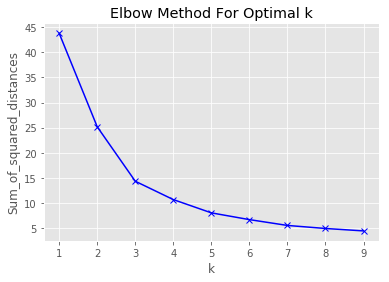

In [547]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('ggplot')

mms = MinMaxScaler()
mms.fit(df_test)
data_transformed = mms.transform(df_test)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, algorithm='auto')
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### best_k=5

In [560]:
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns

k=5
# create model and prediction
#kmeans = KMeans(init = "k-means++", n_clusters = 4, n_init = 10)
kmeans = KMeans(n_clusters=k,algorithm='auto').fit(df_test)
labels = pd.Series(kmeans.labels_)

# predict = pd.DataFrame(kmeans.predict(df))
# predict.columns=['predict']


In [561]:
k_means_cluster_centers = kmeans.cluster_centers_
cluster_center = pd.DataFrame(k_means_cluster_centers)
cluster_center.columns=['lat','lon']
cluster_center

,lat,lon
0,36.357210,127.347135
1,36.351491,127.379035
2,36.373640,127.327085
3,36.390211,127.354694
4,36.372866,127.385151


In [562]:
label_count = labels.groupby(labels).count()
label_count

0    112
1    100
2     56
3     72
4     72
dtype: int64

In [563]:
dflabel = pd.DataFrame({"label": kmeans.labels_})
dflabel.head(5)

,label
0,2
1,2
2,2
3,2
4,2


In [564]:
df.reset_index(drop=True, inplace=True)
dflabel.reset_index(drop=True, inplace=True)

df2 = pd.concat([df, dflabel], axis=1)
df2.head(10)

,t,lat,lon,label
0,False,36.395,127.326,2
1,False,36.395,127.326,2
2,False,36.387,127.324,2
3,False,36.3871,127.318,2
4,False,36.3832,127.321,2
5,False,36.3832,127.32,2
6,False,36.3833,127.319,2
7,False,36.3827,127.321,2
8,False,36.399,127.339,3
9,False,36.3817,127.323,2


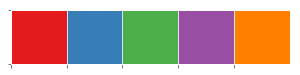

In [565]:
colors = sns.color_palette('Set1', k)
sns.palplot(colors)
hex_colors = colors.as_hex()

In [566]:
mp = folium.Map(location=kaistcode, zoom_start=12, tiles='cartodbpositron')
for _,row in df2.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color = hex_colors[row['label']],
        fill=True,
        fill_opacity=0.5,
        fill_color=hex_colors[row['label']]
    ).add_to(mp)
    
for _,row in cluster_center.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        color='K',
        fill=True,
        fill_opacity=1,
        fill_color='K'
    ).add_to(mp)
    
mp    

check the number of chinese restrants in each clusters

In [555]:
label_0 = df2[df2.label==0]
label_1 = df2[df2.label==1]
label_2 = df2[df2.label==2]
label_3 = df2[df2.label==3]
label_4 = df2[df2.label==4]
label_0.head(5)

,t,lat,lon,label
238,False,36.3752,127.375,0
239,False,36.3768,127.375,0
240,False,36.3652,127.362,0
241,False,36.3632,127.362,0
251,False,36.3773,127.382,0


In [569]:
chinese_0 = label_0[label_0.t == True]
chinese_1 = label_1[label_1.t == True]
chinese_2 = label_1[label_1.t == True]
chinese_3 = label_1[label_1.t == True]
chinese_4 = label_1[label_1.t == True]

print('num of Chinese restaurants in 0 : ', int(chinese_0[['t']].count()) )
print('num of Chinese restaurants in 1 : ', int(chinese_1[['t']].count()) )
print('num of Chinese restaurants in 2 : ', int(chinese_2[['t']].count()) )
print('num of Chinese restaurants in 3 : ', int(chinese_3[['t']].count()) )
print('num of Chinese restaurants in 4 : ', int(chinese_4[['t']].count()) )

num of Chinese restaurants in 0 :  9
num of Chinese restaurants in 1 :  11
num of Chinese restaurants in 2 :  11
num of Chinese restaurants in 3 :  11
num of Chinese restaurants in 4 :  11


Number of chinese restarant in each clusters are similar.
We should consider all the clusters

In [557]:
cluster_center.describe()

,lat,lon
count,3.000000,3.000000
mean,36.369846,127.359992
std,0.017097,0.020651
min,36.357569,127.339880
25%,36.360082,127.349417
50%,36.362596,127.358954
75%,36.375985,127.370048
max,36.389374,127.381143


In [558]:
location_code=cluster_center.mean()

print(location_code)

lat     36.369846
lon    127.359992
dtype: float64


Best location : 36.369084  ,  127.358620

In [559]:
map_kaist = folium.Map(location=kaistcode, zoom_start=13)
folium.Marker(kaistcode, popup='KAIST').add_to(map_kaist)
folium.CircleMarker(location_code, 
                    radius=5, color='red', 
                    fill=True, fill_color='red', 
                    fill_opacity=1).add_to(map_kaist)

map_kaist

### DBSCAN

In [381]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [386]:
df.head(5)

,t,lat,lon
0,False,36.395,127.326
1,False,36.395,127.326
2,False,36.387,127.324
3,False,36.3871,127.318
4,False,36.3832,127.321


In [387]:
#df_DBSC = df.as_matrix().astype("float32", copy = False)
df_DBSC = df[['lat','lon']]
stscaler = StandardScaler().fit(df_DBSC)
df_DBSC = stscaler.transform(df_DBSC)

In [453]:
#dbsc = DBSCAN(eps = 0.23, min_samples = 8, algorithm='ball_tree').fit(df_DBSC)
dbsc = DBSCAN(eps = 0.22, min_samples = 8, algorithm='kd_tree').fit(df_DBSC)

In [454]:
labels = dbsc.labels_
labels

array([-1, -1, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  1,  1,  1,
       -1, -1,  0,  0,  1,  1,  1,  3,  0,  0,  1,  3,  3,  3,  3,  3,  2,
        2,  2,  2,  2, -1, -1, -1,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  4, -1, -1, -1, -1, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2, -1, -1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, -1, -1,
       -1, -1,  2,  2,  2,  4,  4,  4, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  2, -1, -1, -1, -1, -1,  5, -1, -1,  5,  5, -1, -1, -1, -1, -1,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5, -1,  5, -1,  6,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, -1, -1, -1, -1,  6,  6,
        6,  6,  6,  6,  6,  6, -1,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [455]:
df_DBSC_label = df
df_DBSC_label['label']=labels
df_DBSC_label.head()

C:\Users\Tmax\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,t,lat,lon,label
0,False,36.395,127.326,-1
1,False,36.395,127.326,-1
2,False,36.387,127.324,-1
3,False,36.3871,127.318,-1
4,False,36.3832,127.321,0


In [456]:
#n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
n_clusters_ = len(unique_labels)

colors = sns.color_palette('Set1', n_clusters_)
hex_colors = colors.as_hex()

mp_DBSC = folium.Map(location=kaistcode, zoom_start=12, tiles='cartodbpositron')
for _,row in df_DBSC_label.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color= hex_colors[row['label']],
        fill=True,
        fill_opacity=0.5,
        fill_color= hex_colors [row['label']]
    ).add_to(mp_DBSC)

    
mp_DBSC

In [466]:
#remove outlier
df_no_outlier=df_DBSC_label[df_DBSC_label.label!=-1]

In [468]:
mp_DBSC = folium.Map(location=kaistcode, zoom_start=12, tiles='cartodbpositron')
for _,row in df_no_outlier.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color= hex_colors[row['label']],
        fill=True,
        fill_opacity=0.5,
        fill_color= hex_colors [row['label']]
    ).add_to(mp_DBSC)

    
mp_DBSC

In [481]:
def get_label_df(label, df ):
    
    label_df=df[df.label==label]
    
    return label_df

DBSC_label_0 = get_label_df(0, df_DBSC_label)
DBSC_label_1 = get_label_df(1, df_DBSC_label)
DBSC_label_2 = get_label_df(2, df_DBSC_label)
DBSC_label_3 = get_label_df(3, df_DBSC_label)
DBSC_label_4 = get_label_df(4, df_DBSC_label)
DBSC_label_5 = get_label_df(5, df_DBSC_label)
DBSC_label_6 = get_label_df(6, df_DBSC_label)
DBSC_label_7 = get_label_df(7, df_DBSC_label)
DBSC_label_8 = get_label_df(8, df_DBSC_label)
DBSC_label_9 = get_label_df(9, df_DBSC_label)
DBSC_label_10 = get_label_df(10, df_DBSC_label)
DBSC_label_11 = get_label_df(11, df_DBSC_label)
DBSC_label_7.head(5)

,t,lat,lon,label
244,False,36.3558,127.359,7
256,False,36.3581,127.364,7
257,False,36.3568,127.362,7
258,False,36.3571,127.364,7
259,False,36.3557,127.362,7


In [472]:
DBSC_label_0[DBSC_label_0.t==True].count()

t        2
lat      2
lon      2
label    2
dtype: int64

In [482]:
#check the number of chinese restarant in each cluster
#int(DBSC_label_0[DBSC_label_0.t==True].count())

def get_num(label, df ):
    num=int(df[df.label==label][['t']].count()) 
    return num


def get_chinese(df):
    num = int(df[df.t==True][['t']].count())
    return num


print('0:  ',get_chinese(DBSC_label_0),'/',get_num(0, df_no_outlier))
print('1:  ',get_chinese(DBSC_label_1),'/',get_num(1, df_no_outlier))
print('2:  ',get_chinese(DBSC_label_2),'/',get_num(2, df_no_outlier))
print('3:  ',get_chinese(DBSC_label_3),'/',get_num(3, df_no_outlier))
print('4:  ',get_chinese(DBSC_label_4),'/',get_num(4, df_no_outlier))
print('5:  ',get_chinese(DBSC_label_5),'/',get_num(5, df_no_outlier))
print('6:  ',get_chinese(DBSC_label_6),'/',get_num(6, df_no_outlier))
print('7:  ',get_chinese(DBSC_label_7),'/',get_num(7, df_no_outlier))
print('8:  ',get_chinese(DBSC_label_8),'/',get_num(8, df_no_outlier))
print('9:  ',get_chinese(DBSC_label_9),'/',get_num(9, df_no_outlier))
print('10:  ',get_chinese(DBSC_label_10),'/',get_num(10, df_no_outlier))
print('11:  ',get_chinese(DBSC_label_11),'/',get_num(11, df_no_outlier))

0:   2 / 12
1:   1 / 8
2:   7 / 47
3:   1 / 8
4:   2 / 15
5:   8 / 73
6:   3 / 16
7:   0 / 14
8:   4 / 34
9:   0 / 37
10:   1 / 14
11:   3 / 13


we can remove group size under 15 and Don't have any chinese restaurant.


--> We will only use group 2,4,5,6,8

In [570]:
DBSC_new = DBSC_label_2.append(DBSC_label_4)
DBSC_new = DBSC_new.append(DBSC_label_5)
DBSC_new = DBSC_new.append(DBSC_label_6)
DBSC_new = DBSC_new.append(DBSC_label_8)

Get center of the clusters

In [573]:
center_2=pd.DataFrame(DBSC_label_2[['lat','lon']].mean()).T
center_4=pd.DataFrame(DBSC_label_4[['lat','lon']].mean()).T
center_5=pd.DataFrame(DBSC_label_5[['lat','lon']].mean()).T
center_6=pd.DataFrame(DBSC_label_6[['lat','lon']].mean()).T
center_8=pd.DataFrame(DBSC_label_8[['lat','lon']].mean()).T

centers = center_2.append(center_4)
centers = centers.append(center_5)
centers = centers.append(center_6)
centers = centers.append(center_8)
centers 

,lat,lon
0,36.390496,127.351134
0,36.371559,127.339013
0,36.359169,127.349427
0,36.384456,127.378603
0,36.365484,127.380138


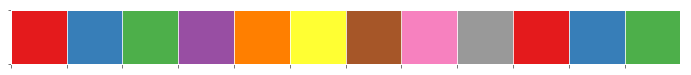

In [581]:
colors = sns.color_palette('Set1',12)
sns.palplot(colors)
hex_colors = colors.as_hex()

In [583]:

mp_DBSC = folium.Map(location=kaistcode, zoom_start=12, tiles='cartodbpositron')
for _,row in DBSC_new.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        color= hex_colors[row['label']],
        fill=True,
        fill_opacity=0.5,
        fill_color= hex_colors [row['label']]
    ).add_to(mp_DBSC)
    
    for _,row in centers.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=6,
            color='K',
            fill=True,
            fill_opacity=0.8,
            fill_color='K'
        ).add_to(mp_DBSC)

    
mp_DBSC

In [586]:
DBSC_loc = centers.mean()

In [587]:
final_location =  (DBSC_loc+location_code+kaistcode)/3

In [589]:
map_kaist = folium.Map(location=kaistcode, zoom_start=16)
folium.Marker(kaistcode, popup='KAIST').add_to(map_kaist)

folium.CircleMarker(location_code, 
                    radius=5, color='red', 
                    fill=True, fill_color='red', 
                    fill_opacity=1,
                    popup='k-means'
                   ).add_to(map_kaist)

folium.CircleMarker(DBSC_loc, 
                    radius=5, color='blue', 
                    fill=True, fill_color='blue', 
                    fill_opacity=1,
                    popup='DBSCAN'
                   ).add_to(map_kaist)

folium.Marker(final_location, 
              popup='Final Location',
              icon=folium.Icon(color='red', icon='info-sign')).add_to(map_kaist)


print('Final Location ' )
print(final_location )
map_kaist

Final Location 
lat     36.372074
lon    127.360015
dtype: float64


## Results and Discussion <a name="results"></a>

Results and Discussion
From this project we figure out two place for the Drone Base.
1. from k-means : [ 36.369084 , 127.358620 ]
2. from DBSCAN : [ 36.374233 , 127.359663 ]
We find restaurants clusters around KAIST based on data from Foursquare.
And also, mark Chinese restaurants to figure out the cluster is meaningful for us.
In case of k-means, we optimized the 'k' using elbow method. But, we couldn't remove outliers.
In case of DBSCAN, we remove outliers. But, it was hard to optimize the parameters. So, we changed the values for parameters based on visualization analysis. 
We select the center of the centers of the clusters. We also have to consider the distance from KAIST. So, we get mean of two place and KAIST. 

The red marker is the Final Location.
### Final Location : [ 36.372074 , 127.360015 ]



---------------------------------------

## Conclusion <a name="conclusion"></a>


From this project we figure out suitable place for the Food Delivery Service Drone Base.
We get data from Google API and Foursquare. From the data from Foursquare, we can get data of restaurants around KAIST. 
Using k-means & DBSCAN, we find out main restaurants clusters around KAIST.
And count the number of Chinese restaurants in the clusters to make sure the cluster is important for our project.
and the result of k-means & DBSCAN was different but, the center of the clusters center was almost same. And optimizing in DBSCAN was based on visualization tool. So, it's hard to say both methods are perfect or mathematically right.
But, it true that from this project we get meaningful data for the business. 
If we try to develop this project, we can consider about other data in real world.

Thank you
